# Wildfire Area Prediction Starting Kit

_Authors: Corentin Ambroise, Bastien Galmiche, Luis Montero, Margaux Zaffran_

## Table of contents

1. [Introduction](#introduction)
    1. [Context](#context)
    2. [Objective](#problematic)
    3. [Benefits](#KPI)
    4. [Dependancies](#librairies)
2. [Data](#data)
    1. [Main dataset](#fires)
    2. [Weather datasets](#weather)
    3. [Forest dataset](#forest)
    4. [INSEE dataset](#insee)
    5. [Split](#split)
3. [Loss](#loss)
4. [Exploratory data analysis](#explo)
    1. [Loading data](#loading_data)
    2. [Fires](#fires_explo)
    3. [Weather and fires](#weather_explo)
    4. [Forest and fires](#forest_explo)
    5. [INSEE and fires](#insee_explo)
5. [Model](#model)
    1. [Feature extractor](#features)
    2. [Regressor](#regressor)
    3. [Baseline model](#baseline)
    4. [Naive merges](#merges)
6. [RAMP submission](#ramp)

## Introduction <a name="introduction"></a>

### Context <a name="Context"></a>

Every summer, the south of France is ravaged by wild fires, due to human activities or natural causes. The firemen struggle fighting theses, and it is hard to estimate the required needs in term of equipement and staff.

### Objective <a name="objective"></a>

Our goal is to estimate the surface that will potentially burn when it is declared in order to know the necessary means to deploy in order to counter its spreading.

### Benefits <a name="benefits"></a>

_Give some KPI (vegetation area preserved, life saved...)_ 

### Dependancies <a name="librairies"></a>

In order to be able to run this notebook, you will need the following dependancies installed:

- pandas
- numpy
- scipy
- matplotlib
- scikit-learn
- geopandas
- pyproj
- shapely
- jupyter
- googledrivedownloader

The dependencies can be installed with ```pip install -r requirements.txt```:

In [1]:
#!pip install -r requirements.txt

## Data <a name="data"></a>

We collected data from a lot of various sources, but mainly what is provided to answer to this challenge are:

- Fire data set
- Weather datasets
- Forests dataset

### Main dataset <a name="fires"></a>

The main dataset comes from Promethee, a french data base which contains various information about different fires that occured in the south of France, including the regions Provence-Alpes-Côte-d'Azur, Corse, the old Languedoc-Roussillon region and a part of the Auvergne-Rhône-Alpes up to St-Etienne. This dataset contains fires that occured between 1973 and 2018.

For each fire, we have different information, each of which corresponds to a column in the dataset:

- __Year__: the year during which the fire occured
- __ID__: a number assigned by the computer when the fire is created in the system
- __Department__: department in which the fire was declared
- __INSEE_code__: code insee of the municipality in which the fire was declared
- __Town__: name of the municipality in which the fire was declared
- __Locality__: supplementary precision about the location
- __DFCI_coordinate__: coordinate of the DFCI square in which the fire was declared. This coordinate system is specific to the french DFCI, and corresponds to a small square of 1km side. You can find more information about this coordinate system <a href='http://ccffpeynier.free.fr/Files/dfci.pdf'>here</a> and how they are encoded in these data <a href='https://www.promethee.com/doc/prom_donnees.pdf'>here</a>
- __Signal__: time at which the fire occured
- __Origin__: which service declared the fire
- __Area__: area burnt by the fire in square meters

![Map](img/map_fires.png)

In the original dataset that you can get on the website of Promethee, the data was not very clean, notably the documentation is out-of-date, and sometimes contradicts itself. So first in the previous section we provide you with an accurate documentation, and moreover we preprocessed the data to make it a bit cleaner. 

The most annoying issue was the lack of geographic precision, due to a poor quality of the DFCI coordinates provided. For fires that occured before 1983, the coordinates provided were not listed in the DFCI coordinate system, and after that there was still some missing characters to have the complete exact coordinates.

An information that we can trust and have for each fire is the department where it occured. So using the geographic shapes of the departements (<a href='https://public.opendatasoft.com/explore/dataset/contours-geographiques-des-departements-2019/information/'> here </a>) and of the DFCI squares coordinates (<a href='https://www.geonov.fr/smartdata/carroyage/'> here </a>), we sampled uniformly within each department the locations of the fires for those who had a poorly encoded coordinate.

### Weather datasets <a name="weather"></a>

Weather condition is surely a determining factor on how will spread a fire. Based on this basic observation, we provide side datasets to help predict the burnt (or potentially burnt) surfaces. 

All the datasets we provide for weather data give various weather indicator in some main stations. These stations are show in the map below:

![Weather_stations_plan](img/map_weather_plan.png)

We provide 3 weather datasets:
- ```synop.csv``` from https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/information/ , goes from 2013 to 2020.
- ```mf_aglomerated.csv``` scraped from https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32 , the archived data from the previous dataset. It goes from 1996 to 2020 but with less columns.
- ```meteo_stations.csv``` scraped from http://www.meteofrance.com/climat/meteo-date-passee , on the insee code of the stations of the two previous dataset from 1973 to 2020. The idea was to provide an extension of the previous datasets for the missing years. This dataset contains less information than the other ones.

#### Synop essentials

Translation table for the columns of the first dataset:

| French name | English translation |
|--|--|
| ID OMM station | WMO station ID |
| Date | Dated |
| Pression au niveau mer | Sea level pressure |
| Variation de pression en 3 heures | Pressure variation in 3 hours |
| Type de tendance barométrique | Type of barometric trend |
| Direction du vent moyen 10 mn | Average wind direction 10 mins |
| Vitesse du vent moyen 10 mn | Average wind speed 10 mins |
| Température | Temperature |
| Point de rosée | Dew point |
| Humidité | Humidity |
| Visibilité horizontale | Horizontal visibility |
| Temps présent | Present time |
| Temps passé 1 | Past weather 1 |
| Temps passé 2 | Past weather 2 |
| Nebulosité totale | Total cloudiness |
| Nébulosité  des nuages de l' étage inférieur | Cloudiness of clouds on the lower level |
| Hauteur de la base des nuages de l'étage inférieur | Height of the cloud base of the lower level |
| Type des nuages de l'étage inférieur | Type of clouds on the lower level |
| Type des nuages de l'étage moyen | Type of mid-level clouds |
| Type des nuages de l'étage supérieur | Type of upper-level clouds |
| Pression station | Station pressure |
| Niveau barométrique | Barometric level |
| Géopotentiel | Geopotential |
| Variation de pression en 24 heures | Pressure variation in 24 hours |
| Température minimale sur 12 heures | Minimum temperature over 12 hours |
| Température minimale sur 24 heures | Minimum 24 hour temperature |
| Température maximale sur 12 heures | Maximum temperature over 12 hours |
| Température maximale sur 24 heures | Maximum temperature over 24 hours |
| Température minimale du sol sur 12 heures | Minimum soil temperature over 12 hours |
| Méthode de mesure Température du thermomètre mouillé | Measuring method Wet thermometer temperature |
| Température du thermomètre mouillé | Wet thermometer temperature |
| Rafale sur les 10 dernières minutes | Burst over the last 10 minutes |
| Rafales sur une période | Gusts over a period |
| Periode de mesure de la rafale | Burst measurement period |
| Etat du sol | Soil condition |
| Hauteur totale de la couche de neige, glace, autre au sol | Total height of the layer of snow, ice, other on the ground |
| Hauteur de la neige fraîche | Height of fresh snow |
| Periode de mesure de la neige fraiche | Period for measuring fresh snow |
| Précipitations dans la dernière heure | Precipitation in the last hour |
| Précipitations dans les 3 dernières heures | Precipitation in the last 3 hours |
| Précipitations dans les 6 dernières heures | Precipitation in the last 6 hours |
| Précipitations dans les 12 dernières heures | Precipitation in the last 12 hours |
| Précipitations dans les 24 dernières heures | Precipitation in the last 24 hours |
| Phénomène spécial 1 | Special phenomenon 1 |
| Phénomène spécial 2 | Special phenomenon 2 |
| Phénomène spécial 3 | Special phenomenon 3 |
| Phénomène spécial 4 | Special phenomenon 4 |
| Nébulosité couche nuageuse 1 | Cloud cover 1 |
| Type nuage 1 | Cloud type 1 |
| Hauteur de base 1 | Basic height 1 |
| Nébulosité couche nuageuse 2 | Cloud cover cloud 2 |
| Type nuage 2 | Cloud type 2 |
| Hauteur de base 2 | Basic height 2 |
| Nébulosité couche nuageuse 3 | Cloud cover 3 |
| Type nuage 3 | Cloud type 3 |
| Hauteur de base 3 | Basic height 3 |
| Nébulosité couche nuageuse 4 | Cloud cover cloudiness 4 |
| Type nuage 4 | Cloud type 4 |
| Hauteur de base 4 | Basic height 4 |
| Coordonnees | Contact information |
| Nom | Name |
| Type de tendance barométrique.1 | Type of barometric trend. 1 |
| Temps passé 1.1 | Time spent 1.1 |
| Temps présent.1 | Present weather.1 |
| Température (°C) | Temperature (° C) |
| Température minimale sur 12 heures (°C) | Minimum temperature over 12 hours (° C) |
| Température minimale sur 24 heures (°C) | Minimum temperature over 24 hours (° C) |
| Température maximale sur 12 heures (°C) | Maximum temperature over 12 hours (° C) |
| Température maximale sur 24 heures (°C) | Maximum temperature over 24 hours (° C) |
| Température minimale du sol sur 12 heures (en °C) | Minimum soil temperature over 12 hours (in ° C) |
| Altitude | Altitude |
| Longitude | Longitude |
| Latitude | Latitude |
| communes (name) | towns (name) |
| communes (code) | municipalities (code) |
| EPCI (name) | EPCI (name) |
| EPCI (code) | EPCI (code) |
| department (name) | department (name) |
| department (code) | department (code) |
| region (name) | region (name) |
| region (code) | region (code) |

Check the table below for more precision the columns.

#### Historic synop
We stack here all the historic data splitted into numerous files on Meteo France platform.

Description of the columns of the dataset:

| Descriptive | Column name | type | unit |
|----------- |------------|------|-------|
| OMM station id | numer_sta | char | |
| Date (UTC) | date | char | AAAAMMDDHHMISS |                
| Pressure at sea level | pmer | int | Pa |
| Pressure variation in 3 hours | tend | int | Pa |
| Type of barometric trend | cod_tend | int | code (0200) |
| Average wind direction 10 mn | dd | int | degree |
| Average wind speed 10 mn | ff | real | m/s |
| Temperature | t | real | K |
| Dew point | td | real | K |
| Humidity | u | int | % |
| Horizontal visibility | vv | real | m |
| Present weather | ww | int | code (4677) |
| Weather past 1 | w1 | int | code (4561) |
| Weather past 2 | w2 | int | code (4561) |
| Total cloudiness | n | real | % |
| Cloudiness of the clouds of the lower level | nbas | int | octa |
| Height of the cloud base of the lower level | hbas | int | mètre |
| Type of clouds on the lower level | cl | int | code (0513) |
| Type of mid-level clouds | cm | int | code (0515) |
| Type of upper-level clouds | ch | int | code (0509) |
| Station pressure | pres | int | Pa |
| Barometric level | niv_bar | int | Pa |
| Geopotential | geop | int | m2/s2 |
| Pressure variation in 24 hours | tend24 | int | Pa |
| Minimum temperature over N hours | tnN | real | K |
| Maximum temperature over N hours | txN | real | K |
| Minimum soil temperature over 12 hours | tminsol | real | K |
| Tw measurement method | sw | int | code (3855) |
| Wet thermometer temperature | tw | real | K |
| Gusts over the last 10 minutes | raf10 | real | m/s |
| Gusts over a period | rafper | real | m/s |
| Burst measurement period | per | real | min |
| Soil condition | etat_sol | int | code (0901) |
| Total height of the layer of snow, ice, other; on the ground | ht_neige | real | m |
| Height of fresh snow | ssfrai | real | m                         |
| Period for measuring fresh snow | perssfrai | real | 1/10 heure|
| Precipitation in the last N hours | rrN | real | mm | 
| Special phenomenon | phenspeN | real | code (3778) |
| Cloudiness cche clouds N | nnuageN | int | octa |
| Cloud type N | ctypeN | int | code (0500) | 
| Basic height N | hnuageN | int | m |

- char : ascii characters
- int : integer
- real : real number (with float)

The numbers in parantheses preceded by the word "code" refer to the code table of the WMO (World Meteorological Organization): https://www.wmo.int/pages/prog/www/WMOCodes/WMO306_vI1/Publications/2017update/WMO306_vI1_2011UP2017_en.pdf.

#### Scraped data
This data was scraped from Meteo France website for every day between the 1st of January of 1973 and the 28th of January of 2020 for every insee code of the stations in the fires data area. The goal here was to complete the previous datasets not to match exactly the fires dataset which could have also been done.

All scripts to collect the data are available in the `data_collecters` folder.

### Forest dataset <a name="forest"></a>

The forest data set we provide you is extracted from an ONF (Office National des Forêts) data set listing the different forests in France, with their shape and location. You can find the original data set <a href=https://www.data.gouv.fr/fr/datasets/forets-publiques-diffusion-publique-1/>here</a>.

Our dataset is slightly different from the original one. First, it only contains forests of the departements for which we have fire data, so departement of the south-east part of France. And secondly, since it takes some time, we precomputed the areas of the forests, which can be used in a regression model. You can find the function which does it in the utils.py file. We will use the geopandas package to read the file which is a geojson. It allows us to have a dataframe containing as columns the properties of the features, and a column geometry containing the geometry of each feature.

We list here what desciptors we have for each forest

- __iidtn_frt__: id of the forest
- __llib_frt__: name of the forest
- __cdom_frt__: wheter it is a state or a communal forest ('NON' for communal forest and 'OUI' for state forests)
- __cinse_dep__: department of the forest
- __area__: the area of the forest inb square meters
- __geometry__: shapely objects describing the shape of a forest (Polygon or MultiPolygon). You can learn how to manipulate these objects <a href=https://shapely.readthedocs.io/en/stable/manual.html>here</a>



We can visualize bellow what these forests look like.

![Forests](img/map_forests.png)

### Split <a name="split"></a>

As we will show it during the exploratory data analysis, our dataset is highly imbalanced. Indeed, there exists two types of fires: it can either be a forest fire, so a regular one, with a minimum burning surface of a square meter, or an AFERPU, only a fire start which did not burn anything really (less than a square meter). The AFERPU ones had been filled with an area of 0.001 square meter each. Obviously we do not provide the category to which each fire belongs, because we do not have this information when a fire actually starts in real life.

Thus, in this dataset you will find a lot of AFERPU (more or less 75%) and only 25% of forest fires. In order to preserve the distribution of the data given this observation and given that our initial dataset is not that large (481940 raws), we've splitted it using a stratified method.

For this, we adapted the classification case by creating levels of fires depending on the area burnt. These method was applied to split the dataset into a public and a private one, and then to split each one into a train set and a test set.

At the end, we've obtained datasets of sizes:

- __public train set:__ (271 091, 10)
- __public test set:__ (90 364, 10)
- __private set:__ (120 485, 10)

## Loss <a name="loss"></a>

Given the previous commentary on our imbalanced data and given the KPI's we want to improve, we can point out 4 caracteristics that our loss would be required to have, in order to learn a model that fits our needs.

- First, we want an asymetric loss which penalizes more under predictions. In our state of mind, in order to prevent a fire to spread, it is best to predict a greater surface burned, in which case we would mobilize more means than necessary, than the opposite.

- Then, we want to penalize more gaps for small values than for big values. For instance, it would be way worst to predict that a fire would burn 0 $m^2$ if it was going to burn 100 $m^2$, than predicting 100 100 $m^2$ or 99 900 $m^2$ burned instead of 100 000 $m^2$. This is why we will apply a log on the prediction and true value before computing their difference.

- In addition we want to penalize more big gaps beetween the prediction and true value, so we will use a powered loss (like MSE)

- And finally, we noticed during the exploratory analysis that most of the fires burned mostly nothing, so the data set is very imbalanced (about 75% of zeros). We need to add something to the loss so it does not always predict zero.

The loss we finally came up with a modified version of the quad quad loss, with $\alpha \in [0,1]$:

$$\mathcal{L}_\alpha\left(y,\hat{y}\right) = 2\left( \alpha + (1-2\alpha)\mathbb{1}_{\{y-\hat{y} < 0\}} \right)\left(log(y) - log(\hat{y}) \right)^{2}$$

The multiplicative coefficient is $2\alpha$ when $y > \hat{y}$ and $2(1-\alpha)$ when $y < \hat{y}$. Thus, to penalize more under predictions we will choose $\alpha > 0.5$. We've set $\alpha = 0.7$.

The total score in a dataset of size $n$ will be computed by:

$$ \text{score} = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} \mathcal{L}_\alpha\left(y_i,\hat{y_i}\right) } $$

We can visualize it as a function of $\hat{y}$ and for various values of $y$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

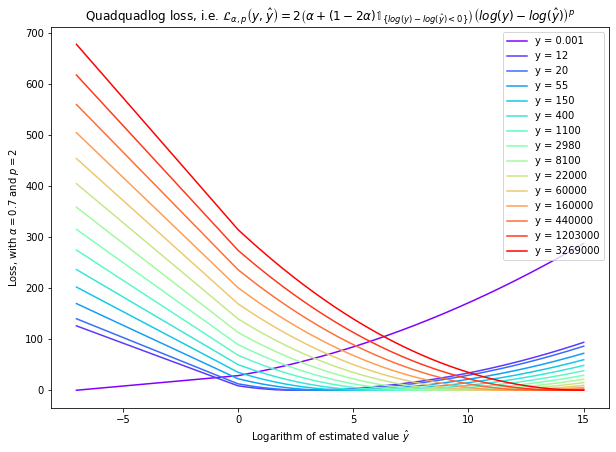

In [2]:
alpha = 0.7
y = [0.001,12,20,55,150,400,1100,2980,8100,22000,60000,160000,440000,1203000,3269000]
ypred = np.arange(0.0009,3270000,1)

def quadquadlog(alpha,y,ypred):
    return 2*(alpha+(1-2*alpha)*(1*((np.log(y)-np.log(ypred)) < 0)))*((np.log(y)-np.log(ypred))**2)

plt.figure(figsize=(10,7))
colors = cm.rainbow(np.linspace(0, 1, len(y)))
for elem, c in zip(y, colors):
    plt.plot(np.log(ypred), quadquadlog(alpha,elem,ypred),color=c,label='y = '+str(elem))
plt.legend(loc='upper right')
plt.xlabel(r'Logarithm of estimated value $\hat{y}$')
plt.ylabel(r'Loss, with $\alpha = 0.7$ and $p = 2$')
plt.title(r'Quadquadlog loss, i.e. $\mathcal{L}_{\alpha,p}\left(y,\hat{y}\right) = 2\left( \alpha + (1-2\alpha)\mathbb{1}_{\{log(y)-log(\hat{y}) < 0\}} \right)\left(log(y) - log(\hat{y}) \right)^{p}$')
plt.show()

## Exploratory data analysis  <a name="explo"></a>

### Loading data  <a name="loading_data"></a>

Downloading public train and test data can be achieved using ```get_train_data``` and ```get_test_data``` functions:

In [3]:
from problem import get_train_data

X_df, y_array = get_train_data()

Downloading the other datasets is done by executing ```download_data```. The files downloaded will be stored in the data folder, as are the main public datasets, but also in the starting_kit folder in the submission folder. The files are retrievied from a private google drive.

In [4]:
!python download_data.py

### Fires  <a name="fires_explo"></a>

_To be done: main dataset analysis_

In [5]:
X_df.head(3)

,Year,ID,Department,INSEE_code,Town,Locality,DFCI_coordinate,Signal,Origin
0,1983,1575,2B,2B337,Valle-di-Rostino,VALLE DI ROSTINO,NC66B42,1983-09-08 15:55:00,3.0
1,1981,2838,83,83057,Flassans-sur-Issole,FLASSANS SUR ISSOLE,KD82A75,1981-05-03 17:20:00,3.0
2,1989,6600,11,11421,Villedaigne,NaN,FC68C63,1989-08-07 14:42:00,NaN


In [6]:
X_df.describe()

,Year,ID,Origin
count,271091.000000,271091.000000,127443.000000
mean,1993.475353,5857.595213,3.048343
std,12.665036,4064.661446,0.834066
min,1973.000000,1.000000,1.000000
25%,1983.000000,2617.000000,3.000000
50%,1991.000000,5246.000000,3.000000
75%,2004.000000,8244.000000,3.000000
max,2018.000000,19750.000000,6.000000


In [7]:
import pandas as pd
X_df['Signal'] = pd.to_datetime(X_df['Signal'], format='%Y-%m-%d %H:%M:%S')

In [8]:
X_df.dtypes

Year                        int64
ID                          int64
Department                 object
INSEE_code                 object
Town                       object
Locality                   object
DFCI_coordinate            object
Signal             datetime64[ns]
Origin                    float64
dtype: object

In [9]:
X_df.isna().sum() / X_df.shape[0]

Year               0.000000
ID                 0.000000
Department         0.000000
INSEE_code         0.000066
Town               0.000066
Locality           0.595877
DFCI_coordinate    0.000000
Signal             0.000000
Origin             0.529888
dtype: float64

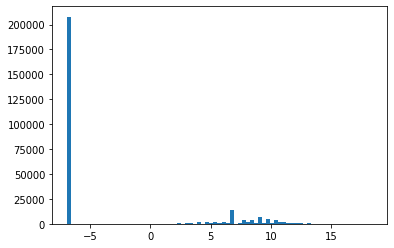

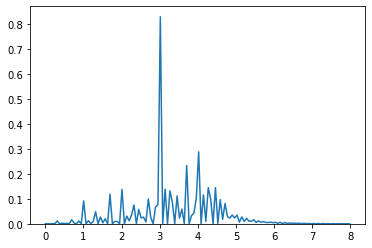

In [12]:
plt.hist(np.log(y_array), bins=75)
plt.show()
np.log(0.0001)
import seaborn
logSur = np.log10(np.clip(y_array, a_min=1, a_max=None))
seaborn.kdeplot(logSur)

This plot shows very well the imbablancing we were refering to earlier. The value with the highest frequency corresponds to $\text{log}(0.001)$ (which is to say, the AFERPU fires).

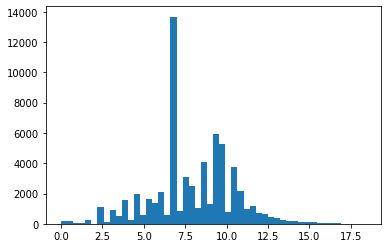

In [13]:
plt.hist(np.log(y_array[y_array != 0.001]), bins=50)
plt.show()

In order to analyse a bit the correlation between X_df and the target (y_array) we temporarily merge them into a ```fires``` dataframe.

In [14]:
fires = pd.concat([X_df, pd.DataFrame({'Area': y_array})], axis=1)
fires.head(10)

,Year,ID,Department,INSEE_code,Town,Locality,DFCI_coordinate,Signal,Origin,Area
0,1983,1575,2B,2B337,Valle-di-Rostino,VALLE DI ROSTINO,NC66B42,1983-09-08 15:55:00,3.0,30000.000
1,1981,2838,83,83057,Flassans-sur-Issole,FLASSANS SUR ISSOLE,KD82A75,1981-05-03 17:20:00,3.0,1000.000
2,1989,6600,11,11421,Villedaigne,NaN,FC68C63,1989-08-07 14:42:00,NaN,0.001
3,2012,3995,30,30189,Nîmes,NaN,HE60D91,2012-03-12 17:38:00,3.0,0.001
4,1989,15627,34,34084,Corneilhan,NaN,GD20B94,1989-09-27 17:15:00,NaN,0.001
5,1979,2091,2B,2B096,Corte,CORTE,NC46L42,1979-08-12 12:56:00,NaN,1000.000
6,1986,13675,66,66136,Perpignan,NaN,FC60B83,1986-07-06 07:46:00,NaN,0.001
7,1973,1585,30,30217,Rochefort-du-Gard,ROCHEFORT DU GARD,HD46E82,1973-09-26 14:35:00,6.0,1000.000
8,2015,7166,30,30036,Bernis,NaN,HD88E73,2015-11-29 16:13:00,NaN,0.001
9,1976,3488,11,11427,Villelongue-d'Aude,NaN,FD80C14,1976-03-18 12:00:00,NaN,0.001


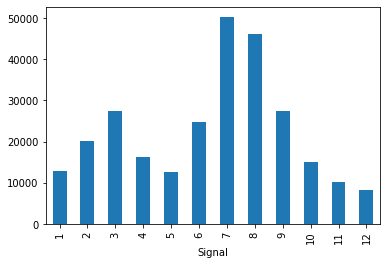

In [15]:
fires.groupby(fires['Signal'].dt.month)['Signal'].count().plot(kind="bar")

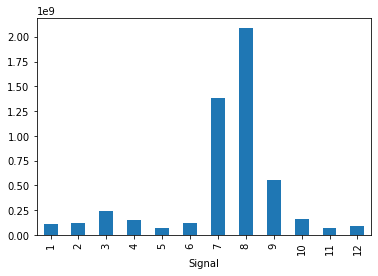

In [16]:
fires.groupby(fires['Signal'].dt.month)['Area'].sum().plot(kind="bar")

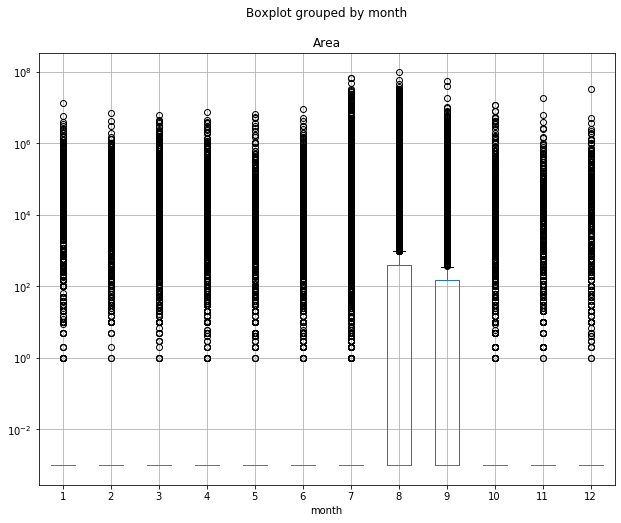

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_yscale('log')
fires['month'] = fires['Signal'].dt.month
fires.boxplot(column=['Area'], by='month', ax=ax)
plt.show()
plt.close()

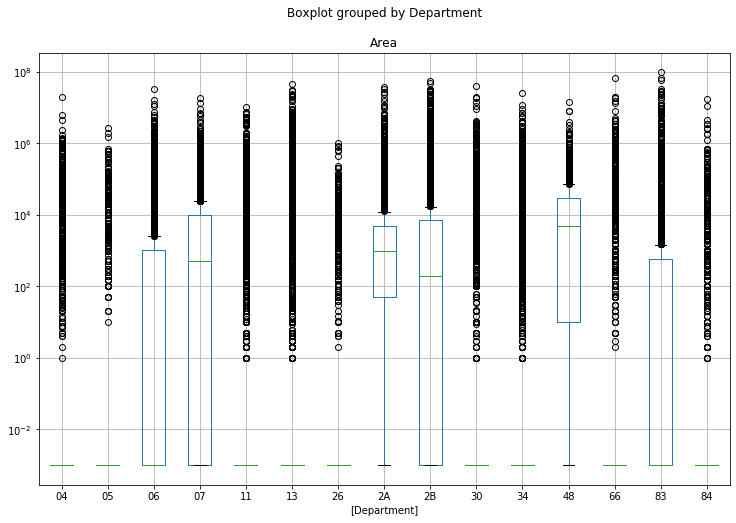

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_yscale('log')
fires.boxplot(column=['Area'], by=['Department'], ax=ax)
plt.show()
plt.close()

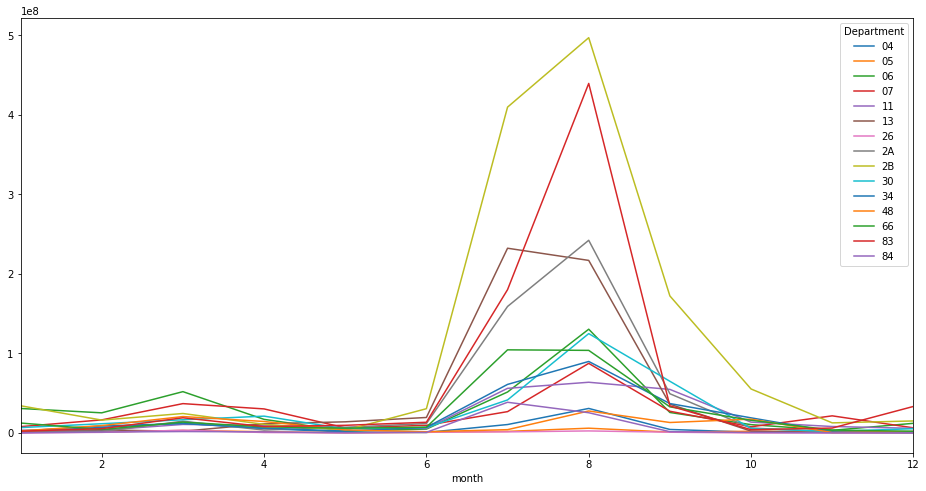

In [19]:
fires.groupby(['month', 'Department'])['Area'].sum().unstack().plot(figsize=(16,8))

We can see that there is a clear seasonality over the months of the year, August having the more burnt surfaces. We can also observe that the magnitude depends a lot on the department.

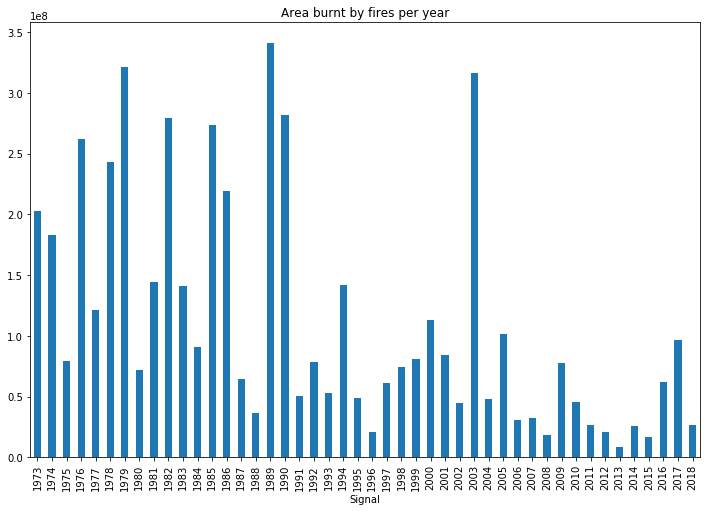

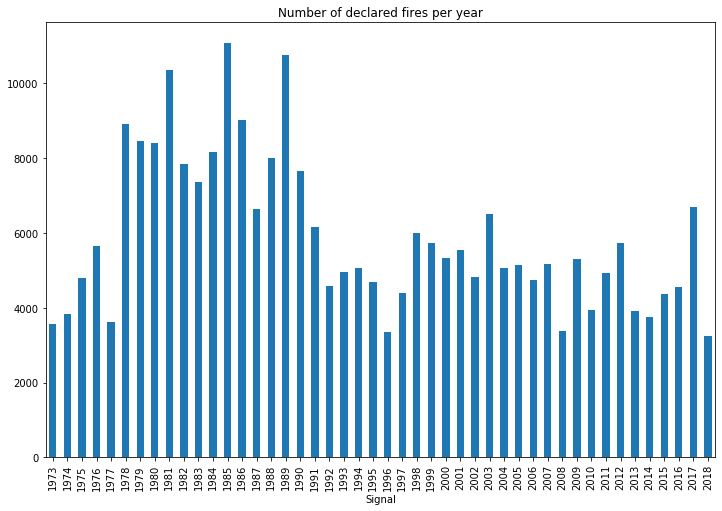

In [20]:
plt.figure(figsize=(12,8))
fires.groupby(fires['Signal'].dt.year)['Area'].sum().plot(kind="bar")
plt.title('Area burnt by fires per year')
plt.show()
plt.close()
plt.figure(figsize=(12,8))
fires.groupby(fires['Signal'].dt.year)['Signal'].count().plot(kind="bar")
plt.title('Number of declared fires per year')
plt.show()
plt.close()

We observe that even if the number of fires does not necessarily decrease, the sum of burnt areas does. 

In [21]:
k = 4
display(fires.groupby(fires['Signal'].dt.year)['Area'].sum().sort_values(ascending=False).head(4))
display(fires.groupby(fires['Signal'].dt.year)['Area'].count().sort_values(ascending=False).head(4))

Signal
1989    3.408530e+08
1979    3.215000e+08
2003    3.165945e+08
1990    2.816880e+08
Name: Area, dtype: float64

Signal
1985    11076
1989    10754
1981    10355
1986     9029
Name: Area, dtype: int64

In [22]:
display(fires.groupby(fires['Department'])['Area'].sum().sort_values(ascending=False).head(4))
display(fires.groupby(fires['Department'])['Area'].count().sort_values(ascending=False).head(4))

Department
2B    1.282521e+09
83    7.560702e+08
13    5.408969e+08
2A    5.015272e+08
Name: Area, dtype: float64

Department
34    49179
30    43394
13    31878
83    25273
Name: Area, dtype: int64

### Weather and fires <a name="weather_explo"></a>

_Analysis of the correlation between weather and fires_



In [23]:
weather_old = pd.read_csv("./data/meteo_stations.csv", sep=";", low_memory=False)
display(weather_old.head(1))
display(weather_old.tail(1))
display(weather_old.shape)

,Unnamed: 0,date,insee_code,daylight duration (hours),rainfall (mm),minimum temperature (celsius),maximal temperature (celsius)
0,0,1973-01-01,43157,NaN,NaN,NaN,NaN


,Unnamed: 0,date,insee_code,daylight duration (hours),rainfall (mm),minimum temperature (celsius),maximal temperature (celsius)
206315,206315,2020-01-27,2B033,7.0,0.0,5.5,15.5


(206316, 7)

In [24]:
weather_old.dtypes

Unnamed: 0                         int64
date                              object
insee_code                        object
daylight duration (hours)        float64
rainfall (mm)                    float64
minimum temperature (celsius)    float64
maximal temperature (celsius)    float64
dtype: object

In [25]:
weather_old.describe()

,Unnamed: 0,daylight duration (hours),rainfall (mm),minimum temperature (celsius),maximal temperature (celsius)
count,206316.000000,190395.000000,190364.000000,190303.000000,190303.000000
mean,103157.500000,6.866598,1.922823,9.368944,18.624328
std,59558.443406,4.350167,6.844834,6.746829,7.527216
min,0.000000,0.000000,0.000000,-23.200000,-14.600000
25%,51578.750000,3.000000,0.000000,4.700000,13.300000
50%,103157.500000,7.000000,0.000000,9.300000,18.300000
75%,154736.250000,10.000000,0.400000,14.600000,24.600000
max,206315.000000,15.000000,299.500000,30.300000,43.500000


In [26]:
weather_old['date'] = pd.to_datetime(weather_old['date'], format='%Y-%m-%d')

In [27]:
weather_old[pd.notna(weather_old['daylight duration (hours)'])]['date'].min(), weather_old['date'].min()

(Timestamp('1973-01-01 00:00:00'), Timestamp('1973-01-01 00:00:00'))

In [28]:
weather_mid = pd.read_csv("./data/mf_aglomerated.csv", sep=",", low_memory=False)
display(weather_mid.head(1))
display(weather_mid.shape)

KeyboardInterrupt: 

In [107]:
weather_mid['date'] = pd.to_datetime(weather_mid['date'])
weather_mid.describe()

,numer_sta,Unnamed: 59
count,4.030576e+06,0.0
mean,2.589927e+04,NaN
std,2.967242e+04,NaN
min,7.005000e+03,NaN
25%,7.222000e+03,NaN
50%,7.577000e+03,NaN
75%,6.197200e+04,NaN
max,8.964200e+04,NaN


In [1]:
weather_recent = pd.read_csv("./data/synop.csv", sep=";", low_memory=False)
display(weather_recent.head(1))
display(weather_recent.shape)

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Longitude,Latitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code)
0,7117,2013-08-24T17:00:00+02:00,101820.0,-30.0,8.0,280.0,7.2,291.05,282.65,58.0,...,-3.473167,48.825833,Perros-Guirec,22168,CA Lannion-Trégor Communauté,200065928.0,Côtes-d'Armor,22,Bretagne,53.0


(1653389, 81)

In [35]:
weather_recent.dtypes

ID OMM station                         int64
Date                                  object
Pression au niveau mer               float64
Variation de pression en 3 heures    float64
Type de tendance barométrique        float64
                                      ...   
EPCI (code)                          float64
department (name)                     object
department (code)                     object
region (name)                         object
region (code)                        float64
Length: 81, dtype: object

In [36]:
weather_recent['Date'] = pd.to_datetime(weather_recent['Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)

In [37]:
weather_recent.dtypes

ID OMM station                                     int64
Date                                 datetime64[ns, UTC]
Pression au niveau mer                           float64
Variation de pression en 3 heures                float64
Type de tendance barométrique                    float64
                                            ...         
EPCI (code)                                      float64
department (name)                                 object
department (code)                                 object
region (name)                                     object
region (code)                                    float64
Length: 81, dtype: object

In [109]:
weather_recent.describe()

,ID OMM station,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,Visibilité horizontale,...,Température minimale sur 12 heures (°C),Température minimale sur 24 heures (°C),Température maximale sur 12 heures (°C),Température maximale sur 24 heures (°C),Température minimale du sol sur 12 heures (en °C),Altitude,Longitude,Latitude,EPCI (code),region (code)
count,1.653389e+06,1.580393e+06,1.474931e+06,1.446837e+06,1.633183e+06,1.633772e+06,1.650329e+06,1.645244e+06,1.644462e+06,1.274058e+06,...,350114.000000,84673.000000,350620.000000,83072.000000,570850.000000,1.653389e+06,1.653389e+06,1.653389e+06,1.435401e+06,1.435401e+06
mean,2.528283e+04,1.015440e+05,3.822172e+00,4.295938e+00,1.762570e+02,4.067414e+00,2.878136e+02,2.830603e+02,7.560130e+01,2.523546e+04,...,10.033873,22.247580,16.389621,29.544607,8.963092,1.336940e+02,3.159661e+00,3.096299e+01,2.259143e+08,5.115588e+01
std,2.941360e+04,9.196019e+02,1.252678e+02,2.712296e+00,1.069444e+02,3.197783e+00,9.339636e+00,8.866599e+00,1.682742e+01,1.690684e+04,...,8.241921,5.817736,9.171747,5.412550,7.030683,1.908873e+02,3.390127e+01,2.884785e+01,2.257746e+07,3.108352e+01
min,7.005000e+03,9.385000e+04,-2.190000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.387500e+02,2.232500e+02,1.000000e+00,0.000000e+00,...,-267.780000,-13.800000,-31.600000,-11.100000,-26.000000,2.000000e+00,-6.285217e+01,-6.666317e+01,2.000187e+08,1.000000e+00
25%,7.207000e+03,1.011400e+05,-7.000000e+01,2.000000e+00,8.000000e+01,1.800000e+00,2.812500e+02,2.774500e+02,6.500000e+01,1.330000e+04,...,4.700000,22.200000,10.200000,29.000000,3.800000,1.100000e+01,-1.411500e+00,1.626400e+01,2.000661e+08,2.800000e+01
50%,7.577000e+03,1.015700e+05,0.000000e+00,3.000000e+00,1.800000e+02,3.300000e+00,2.873500e+02,2.828500e+02,7.800000e+01,2.000000e+04,...,9.900000,23.400000,16.100000,30.600000,8.500000,5.900000e+01,2.384333e+00,4.458117e+01,2.420101e+08,5.300000e+01
75%,6.197200e+04,1.020700e+05,8.000000e+01,7.000000e+00,2.700000e+02,5.600000e+00,2.957500e+02,2.889500e+02,8.900000e+01,3.500000e+04,...,15.200000,25.100000,23.000000,32.000000,13.900000,1.510000e+02,5.959833e+00,4.761433e+01,2.459004e+08,7.600000e+01
max,8.964200e+04,1.091600e+05,2.170000e+03,1.000000e+01,3.600000e+02,9.600000e+01,3.408500e+02,3.730500e+02,1.000000e+02,8.001000e+04,...,47.600000,40.000000,53.500000,40.000000,50.000000,8.710000e+02,1.400010e+02,5.057000e+01,2.497401e+08,9.400000e+01


### Forest and fires <a name="forest_explo"></a>

We will now explore the forests data set in order to have a better idea of what it looks like.

In [39]:
import geopandas as gpd

forests = gpd.read_file('data/forests.json')
forests.head()

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
departments = forests['cinse_dep'].unique()
forests_per_dep = forests[['cinse_dep','area']].groupby('cinse_dep').sum().reset_index()

forests_per_dep.plot(kind='bar', x='cinse_dep', title='Forest area per department')

In [ ]:
target_dep = pd.DataFrame(y_array,columns=['Area'])
target_dep['Department'] = X_df['Department']
sum_year_depart = target_dep.groupby(['Department']).sum().reset_index()

sum_year_depart.plot(x='Department')

In [ ]:
joint_forests_fires = sum_year_depart.set_index('Department').join(forests_per_dep.set_index('cinse_dep'))

joint_forests_fires.corr()

## Model  <a name="model"></a>

### Baseline model  <a name="baseline"></a>

First, we need to transform our date into 6 different columns, so that our regressor can eventually catch a seasonality.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def process_date(X):
    date = pd.to_datetime(X['Signal'], format='%Y-%m-%d %H:%M:%S')
    return np.c_[date.dt.year, date.dt.month, date.dt.day,
                 date.dt.hour, date.dt.minute, date.dt.second]
date_transformer = FunctionTransformer(process_date, validate=False)

Then, we only keep the numbers in the department column.

In [ ]:
def process_dep(X):
    dep_nums = pd.to_numeric(X['Department'], errors='coerce')
    return dep_nums.values[:, np.newaxis]
dep_transformer = FunctionTransformer(process_dep, validate=False)

Again, we only keep the numbers in the INSEE_code column.

In [ ]:
def process_insee(X):
    insee_nums = pd.to_numeric(X['INSEE_code'], errors='coerce')
    return insee_nums.values[:, np.newaxis]
insee_transformer = FunctionTransformer(process_insee, validate=False)

For the numeric columns, we only need a transformer that will deal with missing values:

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])

Again, we only keep the numbers in the origin column.

In [ ]:
def process_origin(X):
    or_nums = pd.to_numeric(X['Origin'], errors='coerce')
    return or_nums.values[:, np.newaxis]
origin_transformer = FunctionTransformer(process_origin, validate=False)

Now, we need to put together the whole pipeline.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_cols = ['ID', 'Year']
insee_col = ['INSEE_code']
date_col = ['Signal']
dep_col = ['Department']
origin_col = ['Origin']

preprocessor = ColumnTransformer(
    transformers=[
        ('date', make_pipeline(date_transformer,
                               SimpleImputer(strategy='median')), date_col),
        ('dep', make_pipeline(dep_transformer,
                              SimpleImputer(strategy='median')), dep_col),
        ('insee', make_pipeline(insee_transformer,
                                SimpleImputer(strategy='median')), insee_col),
        ('num', numeric_transformer, num_cols),
        ('origin', make_pipeline(origin_transformer,SimpleImputer(strategy='median')), origin_col),
        ])

Before trying to train a model with it, we should check that it works correctly:

In [ ]:
preprocessor.fit_transform(X_df)

As a first model, we propose a simple random forest regressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=5, max_depth=50, random_state=4)

We need to implement our loss in the notebook so that we can use to assess the performance of our proposition:

In [ ]:
from sklearn.metrics import make_scorer

def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    alpha = 0.7

    losses = 2*(alpha+(1-2*alpha)*(1*((np.log(y_true)-np.log(y_pred)) < 0)))*((np.log(y_true)-np.log(y_pred))**2)

    loss = np.sqrt(np.mean(losses))

    return loss
    
wfa_loss = make_scorer(loss, greater_is_better=False)

We are now ready to create the full pipeline and evaluate it by a stratified cross-validation, creating level of area burnt.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

reg = Pipeline(steps=[('preprocessing', preprocessor),
                      ('regressor', regressor)])

bins = np.linspace(0,np.log(116000000),25)
y_binned = np.digitize(np.log(y_array),bins)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
splits = cv.split(X_df, y_binned)

scores_baseline = -cross_val_score(reg, X_df, y_array, cv=splits, scoring=wfa_loss)

print("mean: %e (+/- %e)" % (scores_baseline.mean(), scores_baseline.std()))

### Workflow  <a name="workflow"></a>

In order to submit in the RAMP server, you will have to implement two classes, the class ```FeatureExtractor``` and the class ```Regressor```, each one saved respectively in the file ```FeatureExtractor.py``` and ```Regressor.py```.

The ```FeatureExtractor``` is where you should implement all your preprocessing: cleaning, imputing, merges with our complementary datasets, feature engineering and so on. It will return an array of features, your features, that will be given to your regressor during the workflow.

The ```Regressor``` is your model, which will predict the outputs from the features it will have been given before.

Then, your score will be calculated using the loss we've defined previously, called ```wfa_loss```. 

This workflow will be completed in a cross validation scheme, which means that for each fold you will get 3 scores: the one on the train folds, the one on the valid fold and the one on the test fold, this one being a constant fold. The train and valid ones are obtained by stratified cross-validation (having converted the target continuous into level of area) on the train dataset. In the server, the same will be done but using the private test set and computing the cross-validation on the private train set. In order that you don't overfit the private test set, the score you will see in the leaderboard before the challenge ends will be the mean of the valid scores of each fold. The final ranking will be made using the mean of the test scores.

### Feature extractor  <a name="features"></a>

The previous preprocessing should be saved in the ```feature_extractor.py``` file of your submission folder (in our current case in the submissions/starting_kit folder) in order to submit it on ramp (or test it locally, as we will explain later one). This file should implement a FeatureExtractor class, which requires a fit() and transform() method. The fit() method takes as argument X_df but also y_array, so you can use the target in the fitting, meaning that you can do target encoding. However, the transform() method obviously takes only X_df as argument. Below is the equivalent of what we've done before, implementing this class:

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):

        def process_insee(X):
            insee_nums = pd.to_numeric(X['INSEE_code'], errors='coerce')
            return insee_nums.values[:, np.newaxis]
        insee_transformer = FunctionTransformer(process_insee, validate=False)

        def process_dep(X):
            dep_nums = pd.to_numeric(X['Department'], errors='coerce')
            return dep_nums.values[:, np.newaxis]
        dep_transformer = FunctionTransformer(process_dep, validate=False)

        def process_origin(X):
            or_nums = pd.to_numeric(X['Origin'], errors='coerce')
            return or_nums.values[:, np.newaxis]
        origin_transformer = FunctionTransformer(process_origin, validate=False)

        numeric_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])

        def process_date(X):
            date = pd.to_datetime(X['Signal'], format='%Y-%m-%d %H:%M:%S')
            return np.c_[date.dt.year, date.dt.month, date.dt.day,
                         date.dt.hour, date.dt.minute, date.dt.second]
        date_transformer = FunctionTransformer(process_date, validate=False)

        num_cols = ['ID', 'Year']
        insee_col = ['INSEE_code']
        date_col = ['Signal']
        dep_col = ['Department']
        origin_col = ['Origin']

        preprocessor = ColumnTransformer(
            transformers=[
                ('insee', make_pipeline(insee_transformer,
                                        SimpleImputer(strategy='median')), insee_col),
                ('num', numeric_transformer, num_cols),
                ('date', make_pipeline(date_transformer,SimpleImputer(strategy='median')), date_col),
                ('dep', make_pipeline(dep_transformer,SimpleImputer(strategy='median')), dep_col),
                ('origin', make_pipeline(origin_transformer,SimpleImputer(strategy='median')), origin_col),
                ])

        self.preprocessor = preprocessor
        self.preprocessor.fit(X_df, y_array)
        return self

    def transform(self, X_df):
        return self.preprocessor.transform(X_df)

### Regressor  <a name="regressor"></a>

As before, our previous regressor should be implemented in the ```regressor.py```file of your submission folder in order to submit it on ramp. This file should implement a Regressor class, which should have fit() and predict() methods. Here is an example of such a file, given our basic example:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5, max_depth=50, max_features=10)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

### Naive merges  <a name="merges"></a>

Now that we've implemented and tested a basic model, we can try to see wether we can make an improvment with a very naive merge with our additionals datasets (weather and forests). We will use the same preprocessing for the columns of the main dataset.

#### Merge with the oldest weather dataset

In [ ]:
def merge_naive_weather_old(X):
    X['Date'] = pd.to_datetime(X['Signal'], format='%Y-%m-%d %H:%M:%S').dt.floor('d')  
    df = pd.merge(X, weather_old, left_on=['Date', 'INSEE_code'], right_on=['date','insee_code'], how='left')
    return df['maximal temperature (celsius)'].values[:, np.newaxis]
merge_weather_old_transformer = FunctionTransformer(merge_naive_weather_old, validate=False)

In [ ]:
merge_cols = ['Signal', 'INSEE_code'] 
# You need to define the columns of X_df that will be necessary for the transformer.

preprocessor_merge_weather_old = ColumnTransformer(
    transformers=[
        ('date', make_pipeline(date_transformer,SimpleImputer(strategy='median')), date_col),
        ('dep', make_pipeline(dep_transformer,SimpleImputer(strategy='median')), dep_col),
        ('insee', make_pipeline(insee_transformer,SimpleImputer(strategy='median')), insee_col),
        ('num', numeric_transformer, num_cols),
        ('origin', make_pipeline(origin_transformer,SimpleImputer(strategy='median')), origin_col),
        ('merge', make_pipeline(merge_weather_old_transformer, SimpleImputer(strategy='median')), merge_cols),
        ])

preprocessor_merge_weather_old.fit_transform(X_df)

In [ ]:
regressor = RandomForestRegressor(n_estimators=5, max_depth=50, random_state=4)

In [ ]:
reg = Pipeline(steps=[('preprocessing', preprocessor_merge_weather_old),
                      ('regressor', regressor)])

bins = np.linspace(0,np.log(116000000),25)
y_binned = np.digitize(np.log(y_array),bins)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
splits = cv.split(X_df, y_binned)

scores_merge_weather_old = -cross_val_score(reg, X_df, y_array, cv=splits, scoring=wfa_loss)

print("mean: %e (+/- %e)" % (scores_merge_weather_old.mean(), scores_merge_weather_old.std()))

We can compare the two scores:

In [ ]:
scores = pd.DataFrame({'Baseline': scores_baseline, 'Merge weather old': scores_merge_weather_old})
scores.boxplot()

#### Merge with the closest weather dataset

In [ ]:
def merge_naive_weather_recent(X):
    X['Date'] = pd.to_datetime(X['Signal'], format='%Y-%m-%d %H:%M:%S', utc=True).dt.floor('H')  
    X['Communes'] = X['Town'].str.lower()
    X['Communes'] = X['Communes'].str.replace('[^\w]','')
    weather_r = weather_recent.copy()
    weather_r['Date'] = pd.to_datetime(weather_r['Date'], format='%Y-%m-%d %H:%M:%S').dt.floor('H')
    weather_r['communes'] = weather_r['communes (name)'].str.lower()
    weather_r['communes'] = weather_r['communes'].str.replace('[^\w]','')
    df = pd.merge(X, weather_r, left_on=['Date', 'Communes'], right_on=['Date','communes'], how='left')
    return df['Température'].values[:, np.newaxis]
merge_weather_recent_transformer = FunctionTransformer(merge_naive_weather_recent, validate=False)

In [ ]:
merge_cols = ['Signal', 'Town']

preprocessor_merge_weather_recent = ColumnTransformer(
    transformers=[
        ('date', make_pipeline(date_transformer,SimpleImputer(strategy='median')), date_col),
        ('dep', make_pipeline(dep_transformer,SimpleImputer(strategy='median')), dep_col),
        ('insee', make_pipeline(insee_transformer,SimpleImputer(strategy='median')), insee_col),
        ('num', numeric_transformer, num_cols),
        ('origin', make_pipeline(origin_transformer,SimpleImputer(strategy='median')), origin_col),
        ('merge', make_pipeline(merge_weather_recent_transformer, SimpleImputer(strategy='median')), merge_cols),
        ])

preprocessor_merge_weather_recent.fit_transform(X_df)

In [ ]:
regressor = RandomForestRegressor(n_estimators=5, max_depth=50, random_state=4)

In [ ]:
reg = Pipeline(steps=[('preprocessing', preprocessor_merge_weather_recent),
                      ('regressor', regressor)])

bins = np.linspace(0,np.log(116000000),25)
y_binned = np.digitize(np.log(y_array),bins)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
splits = cv.split(X_df, y_binned)

scores_merge_weather_recent = -cross_val_score(reg, X_df, y_array, cv=splits, scoring=wfa_loss)

print("mean: %e (+/- %e)" % (scores_merge_weather_recent.mean(), scores_merge_weather_recent.std()))

In [ ]:
scores = pd.DataFrame({'Baseline': scores_baseline, 'Merge weather old': scores_merge_weather_old,
                       'Merge weather recent': scores_merge_weather_recent})
scores.boxplot()

#### Merge with the forest dataset

In [ ]:
def merge_naive_forests(X):
    forests_per_dep = forests[['cinse_dep','area']].groupby('cinse_dep').sum().reset_index()
    forests_per_dep['mean'] = forests[['cinse_dep','area']].groupby('cinse_dep').mean().values
    df = pd.merge(X, forests_per_dep, left_on=['Department'], right_on=['cinse_dep'], how='left')
    return df[['area','mean']]
merge_forests_transformer = FunctionTransformer(merge_naive_forests, validate=False)

In [ ]:
merge_col = ['Department']

preprocessor_merge_forests = ColumnTransformer(
    transformers=[
        ('date', make_pipeline(date_transformer,SimpleImputer(strategy='median')), date_col),
        ('dep', make_pipeline(dep_transformer,SimpleImputer(strategy='median')), dep_col),
        ('insee', make_pipeline(insee_transformer,SimpleImputer(strategy='median')), insee_col),
        ('num', numeric_transformer, num_cols),
        ('origin', make_pipeline(origin_transformer,SimpleImputer(strategy='median')), origin_col),
        ('merge', make_pipeline(merge_forests_transformer, SimpleImputer(strategy='median')), merge_col),
        ])

preprocessor_merge_forests.fit_transform(X_df)

In [ ]:
regressor = RandomForestRegressor(n_estimators=5, max_depth=50, random_state=4)

In [ ]:
reg = Pipeline(steps=[('preprocessing', preprocessor_merge_forests),
                      ('regressor', regressor)])

bins = np.linspace(0,np.log(116000000),25)
y_binned = np.digitize(np.log(y_array),bins)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
splits = cv.split(X_df, y_binned)

scores_merge_forests = -cross_val_score(reg, X_df, y_array, cv=splits, scoring=wfa_loss)

print("mean: %e (+/- %e)" % (scores_merge_forests.mean(), scores_merge_forests.std()))

In [ ]:
scores = pd.DataFrame({'Baseline': scores_baseline, 'Weather old': scores_merge_weather_old,
                       'Weather recent': scores_merge_weather_recent, 'Merge forests': scores_merge_forests})
scores.boxplot()

## RAMP submission <a name="ramp"></a>

Once you are happy with your model and its score, you can test it locally with the RAMP library to be sure everything works correctly before submitting on the RAMP server.

The files we've defined before (```feature_extractor.py``` and ```regressor.py``` should be in the same folder, named for example ```starting_kit```, along with the complementary datasets - weather and forests - if you use them). Then, you can execute from the ```Wildfire_Area```folder the following command:

In [ ]:
!ramp_test_submission --submission starting_kit

Little note: we've ensured that our loss penalize sufficiently our imbalanced data by creating a ```dumb_predictor``` that always predict 0.001. You can find it in the dumb_predictor file, and test it:

In [ ]:
!ramp_test_submission --submission dumb_predictor